In [20]:
#%pip install optuna-integration[lightgbm]

import lightgbm as lgb
import numpy as np
import pandas as pd
import numpy as np
import gc
import os
import optuna
from optuna.integration import LightGBMPruningCallback
import sqlite3

In [21]:
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')

In [22]:
# Abrir el archivo parquet y cargarlo en un DataFrame data/l_vm_completa_train_pendientes.parquet
df_pendientes = pd.read_parquet('./data/l_vm_completa_train_pendientes.parquet', engine='fastparquet')
# Reunir los DataFrames df_full y df_pendientes por PRODUCT_ID, CUSTOMER_ID y PERIODO, agregar las 
# columnas de df_pendientes a df_full
df_full = df_full.merge(df_pendientes, on=['PRODUCT_ID', 'CUSTOMER_ID', 'PERIODO'], how='left', suffixes=('', '_features'))
# Imprimir las columnas de df_full
print("Columnas de df_full después de la unión con df_pendientes:")
print(df_full.columns.tolist())

Columnas de df_full después de la unión con df_pendientes:
['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID', 'PLAN_PRECIOS_CUIDADOS', 'CUST_REQUEST_QTY', 'CUST_REQUEST_TN', 'TN', 'STOCK_FINAL', 'MEDIA_MOVIL_3M_CLI_PROD', 'MEDIA_MOVIL_6M_CLI_PROD', 'MEDIA_MOVIL_12M_CLI_PROD', 'DESVIO_MOVIL_3M_CLI_PROD', 'DESVIO_MOVIL_6M_CLI_PROD', 'DESVIO_MOVIL_12M_CLI_PROD', 'MEDIA_MOVIL_3M_PROD', 'MEDIA_MOVIL_6M_PROD', 'MEDIA_MOVIL_12M_PROD', 'DESVIO_MOVIL_3M_PROD', 'DESVIO_MOVIL_6M_PROD', 'DESVIO_MOVIL_12M_PROD', 'MEDIA_MOVIL_3M_CLI', 'MEDIA_MOVIL_6M_CLI', 'MEDIA_MOVIL_12M_CLI', 'DESVIO_MOVIL_3M_CLI', 'DESVIO_MOVIL_6M_CLI', 'DESVIO_MOVIL_12M_CLI', 'TN_LAG_01', 'TN_LAG_02', 'TN_LAG_03', 'TN_LAG_04', 'TN_LAG_05', 'TN_LAG_06', 'TN_LAG_07', 'TN_LAG_08', 'TN_LAG_09', 'TN_LAG_10', 'TN_LAG_11', 'TN_LAG_12', 'TN_LAG_13', 'TN_LAG_14', 'TN_LAG_15', 'CLASE', 'CLASE_DELTA', 'ORDINAL', 'TN_DELTA_01', 'TN_DELTA_02', '

In [23]:
# Agregar a df_full una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
df_full['MES_PROBLEMATICO'] = df_full['PERIODO'].apply(lambda x: 1 if x in [201906, 201908] else 0)

In [24]:
# Optimizar tipos de datos numéricos
for col in df_full.select_dtypes(include=['int64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='integer')
for col in df_full.select_dtypes(include=['float64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='float')
# Variables categóricas
# categorical_features = ['ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','CUSTOMER_ID','PRODUCT_ID','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','PLAN_PRECIOS_CUIDADOS','MES_PROBLEMATICO']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')
# Hacer que A_PREDECIR sea boolean si es 'S' vale True, si es 'N' False
df_full['A_PREDECIR'] = df_full['A_PREDECIR'].map({'S': True, 'N': False})


In [25]:
# Variables predictoras y objetivo
# filtrar que en X el periodo sea menor o igual a 201910
# En x eliminar la columna 'CLASE' y 'CLASE_DELTA'
X = df_full[df_full['PERIODO'] <= 201910].drop(columns=['CLASE', 'CLASE_DELTA']) 
# Filtrar en y que el periodo sea menor o igual a 201910
y = df_full[df_full['PERIODO'] <= 201910]['CLASE_DELTA']
# Eliminar df_full para liberar memoria
del df_full
gc.collect()

0

In [26]:
# Definir los periodos de validación 201910
#periodos_valid = [201910]
periodos_valid = [201910]

# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['PERIODO'] < periodos_valid[0]]
y_train = y[X['PERIODO'] < periodos_valid[0]]
X_val_list = [X[X['PERIODO'] == p] for p in periodos_valid]
y_val_list = [y[X['PERIODO'] == p] for p in periodos_valid]
del X, y
gc.collect()

0

In [27]:
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
import os

# === Usamos solo el primer período de validación ===
X_val = X_val_list[0]
y_val = y_val_list[0]

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)


In [ ]:

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',  # alias de l1
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 31, 1024, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 24),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'verbose': -1,
        'feature_pre_filter': False,
        'bagging_seed': 42,
        'feature_fraction_seed': 42
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],  # No usar valid_names
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100),
            LightGBMPruningCallback(trial, 'l1')  # Este es el nombre correcto
        ]
    )

    best_score = model.best_score['valid_0']['l1']
    print(f"Trial {trial.number}: MAE = {best_score:.5f}")
    return best_score

# Optuna
storage_url = "sqlite:///./modelos/optuna.db"
study = optuna.create_study(
    direction='minimize',
    study_name="mae_delta_lgbm_regression_todos_los_productos_con_pendientes",
    storage=storage_url,
    load_if_exists=True
)
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(study.best_params)


In [28]:
# Obtener los mejores hiperparámetros del estudio de la base de datos SQLite
storage_url = "sqlite:///./modelos/optuna.db"
study = optuna.load_study(
    study_name="mae_delta_lgbm_regression_todos_los_productos_con_pendientes",
    storage=storage_url
)
best_params = study.best_params
study.best_params

{'num_leaves': 159,
 'learning_rate': 0.15976562141122164,
 'feature_fraction': 0.9902705425545245,
 'bagging_fraction': 0.9641034133841936,
 'bagging_freq': 3,
 'min_data_in_leaf': 311,
 'max_depth': 18,
 'lambda_l1': 2.4322841274280815,
 'lambda_l2': 0.4206330467495403,
 'min_gain_to_split': 0.9020185871164503}

In [29]:

# Entrenamiento final
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'mae'
best_params['verbose'] = -1

model_reg = lgb.train(
    best_params,
    train_data,
    num_boost_round=50000,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=500),
        lgb.log_evaluation(period=500)
    ]
)

os.makedirs('./modelos', exist_ok=True)
model_reg.save_model('./modelos/lgbm_model_reg_todos_los_productos.txt')



Training until validation scores don't improve for 500 rounds
[500]	valid_0's l1: 0.0508179
Early stopping, best iteration is:
[243]	valid_0's l1: 0.0502319


                      feature    importance
52                TN_DELTA_01  5.333540e+06
8                     ID_CAT3  1.699108e+06
74      PENDIENTE_TENDENCIA_3  1.394175e+06
54                TN_DELTA_03  1.321291e+06
71                 MEDIA_PROD  1.267442e+06
16                         TN  1.240481e+06
53                TN_DELTA_02  1.122404e+06
84      PENDIENTE_TENDENCIA_9  9.649020e+05
69          CANT_PROD_CLI_PER  9.438581e+05
36                  TN_LAG_01  8.995127e+05
12                 PRODUCT_ID  8.433797e+05
9                    ID_BRAND  8.000335e+05
79      PENDIENTE_TENDENCIA_6  7.766121e+05
70             MEDIA_PROD_PER  7.091040e+05
57                TN_DELTA_06  6.924990e+05
55                TN_DELTA_04  6.640851e+05
2                         MES  6.589357e+05
11                CUSTOMER_ID  6.405387e+05
56                TN_DELTA_05  6.146077e+05
38                  TN_LAG_03  6.103073e+05
39                  TN_LAG_04  6.081877e+05
14           CUST_REQUEST_QTY  5

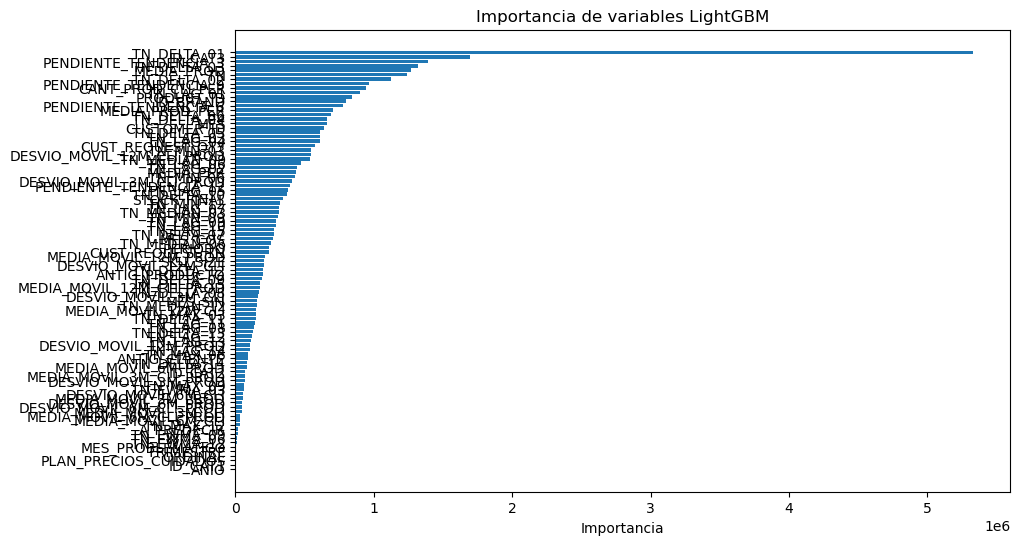

In [45]:
# Obtener la importancia de cada variable
importancia = model_reg.feature_importance(importance_type='gain')
nombres = X_train.columns

# Crear un DataFrame ordenado por importancia
df_importancia = pd.DataFrame({'feature': nombres, 'importance': importancia})
df_importancia = df_importancia.sort_values(by='importance', ascending=False)

# Mostrar las variables más importantes
print(df_importancia.head(50))


# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables LightGBM')
plt.xlabel('Importancia')
plt.show()

In [31]:
# Entreno nuevamente el modelo con los mejores hiperparámetros y el conjunto completo de datos
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')
# Abrir el archivo parquet y cargarlo en un DataFrame data/l_vm_completa_train_pendientes.parquet
df_pendientes = pd.read_parquet('./data/l_vm_completa_train_pendientes.parquet', engine='fastparquet')
# Reunir los DataFrames df_full y df_pendientes por PRODUCT_ID, CUSTOMER_ID y PERIODO, agregar las 
# columnas de df_pendientes a df_full
df_full = df_full.merge(df_pendientes, on=['PRODUCT_ID', 'CUSTOMER_ID', 'PERIODO'], how='left', suffixes=('', '_features'))
# Agregar a df_full una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
df_full['MES_PROBLEMATICO'] = df_full['PERIODO'].apply(lambda x: 1 if x in [201906, 201908] else 0)
# Optimizar tipos de datos numéricos
for col in df_full.select_dtypes(include=['int64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='integer')
for col in df_full.select_dtypes(include=['float64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='float')
# Variables categóricas
# categorical_features = ['ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','CUSTOMER_ID','PRODUCT_ID','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','PLAN_PRECIOS_CUIDADOS','MES_PROBLEMATICO','A_PREDECIR']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')
# Variables predictoras y objetivo
# filtrar que en X el periodo sea menor o igual a 201910
# En x eliminar la columna 'CLASE' y 'CLASE_DELTA'
X = df_full[df_full['PERIODO'] <= 201910].drop(columns=['CLASE', 'CLASE_DELTA']) 
# Filtrar en y que el periodo sea menor o igual a 201910
y = df_full[df_full['PERIODO'] <= 201910]['CLASE_DELTA']
# Eliminar df_full para liberar memoria
del df_full
gc.collect()
# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X
y_train = y
del X, y
gc.collect()

0

In [32]:
# Obtener los mejores hiperparámetros del estudio de la base de datos SQLite
storage_url = "sqlite:///./modelos/optuna.db"
study1 = optuna.load_study(
    study_name="mae_delta_lgbm_regression_todos_los_productos_con_pendientes",
    storage=storage_url
)
best_params1 = study1.best_params
study1.best_params

{'num_leaves': 159,
 'learning_rate': 0.15976562141122164,
 'feature_fraction': 0.9902705425545245,
 'bagging_fraction': 0.9641034133841936,
 'bagging_freq': 3,
 'min_data_in_leaf': 311,
 'max_depth': 18,
 'lambda_l1': 2.4322841274280815,
 'lambda_l2': 0.4206330467495403,
 'min_gain_to_split': 0.9020185871164503}

In [33]:

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)

# Entrenamiento final
best_params = study1.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'mae'
best_params['verbose'] = -1

model_reg = lgb.train(
    best_params,
    train_data,
    num_boost_round=250
)

os.makedirs('./modelos', exist_ok=True)
model_reg.save_model('./modelos/lgbm_model_reg_todos_los_productos.txt')

In [34]:
del df_full
gc.collect()

NameError: name 'df_full' is not defined

In [35]:
# Cargo los datos sobre los que quiero hacer predicciones
gc.collect()
df_pred_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')
df_pred_full = df_pred_full[df_pred_full['PERIODO'] == 201910].drop(columns=['CLASE', 'CLASE_DELTA'])

In [36]:
df_pendientes = pd.read_parquet('./data/l_vm_completa_train_pendientes.parquet', engine='fastparquet')
df_pendientes = df_pendientes[df_pendientes['PERIODO'] == 201910]

In [37]:

df_pred_full = df_pred_full.merge(df_pendientes, on=['PRODUCT_ID', 'CUSTOMER_ID', 'PERIODO'], how='left', suffixes=('', '_features'))


In [20]:
# Mostrar los valores únicos de A_PREDECIR
print("Valores únicos de A_PREDECIR en df_pred_full:")
print(df_pred_full['A_PREDECIR'].unique())

Valores únicos de A_PREDECIR en df_pred_full:
['S' 'N']


In [38]:
# Filtrar solo los que tengan la columna A_PREDECIR con valor 1
df_pred_full = df_pred_full[df_pred_full['A_PREDECIR'] == 'S']
# Hacer que A_PREDECIR sea boolean si es 'S' vale True, si es 'N' False
df_pred_full['A_PREDECIR'] = df_pred_full['A_PREDECIR'].map({'S': True, 'N': False})

# Agregar a df_pred_full una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
df_pred_full['MES_PROBLEMATICO'] = df_pred_full['PERIODO'].apply(lambda x: 1 if x in [201906, 201908] else 0)
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_pred_full[col] = df_pred_full[col].astype('category')

In [39]:
# Eliminar del dataframe df_pred_full la columna 'PREDICCIONES'
if 'PREDICCIONES' in df_pred_full.columns:
    df_pred_full.drop(columns=['PREDICCIONES'], inplace=True)

In [40]:

if not df_pred_full.empty:
	predictions = model_reg.predict(df_pred_full)
	df_pred_full['PREDICCIONES'] = predictions
else:
	print("df_pred_full está vacío, no se generaron predicciones.")


In [48]:
# Mostar las columnas de df_pred_full
print("Columnas de df_pred_full después de las predicciones:")
print(df_pred_full.columns.tolist())

Columnas de df_pred_full después de las predicciones:
['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID', 'PLAN_PRECIOS_CUIDADOS', 'CUST_REQUEST_QTY', 'CUST_REQUEST_TN', 'TN', 'STOCK_FINAL', 'MEDIA_MOVIL_3M_CLI_PROD', 'MEDIA_MOVIL_6M_CLI_PROD', 'MEDIA_MOVIL_12M_CLI_PROD', 'DESVIO_MOVIL_3M_CLI_PROD', 'DESVIO_MOVIL_6M_CLI_PROD', 'DESVIO_MOVIL_12M_CLI_PROD', 'MEDIA_MOVIL_3M_PROD', 'MEDIA_MOVIL_6M_PROD', 'MEDIA_MOVIL_12M_PROD', 'DESVIO_MOVIL_3M_PROD', 'DESVIO_MOVIL_6M_PROD', 'DESVIO_MOVIL_12M_PROD', 'MEDIA_MOVIL_3M_CLI', 'MEDIA_MOVIL_6M_CLI', 'MEDIA_MOVIL_12M_CLI', 'DESVIO_MOVIL_3M_CLI', 'DESVIO_MOVIL_6M_CLI', 'DESVIO_MOVIL_12M_CLI', 'TN_LAG_01', 'TN_LAG_02', 'TN_LAG_03', 'TN_LAG_04', 'TN_LAG_05', 'TN_LAG_06', 'TN_LAG_07', 'TN_LAG_08', 'TN_LAG_09', 'TN_LAG_10', 'TN_LAG_11', 'TN_LAG_12', 'TN_LAG_13', 'TN_LAG_14', 'TN_LAG_15', 'ORDINAL', 'TN_DELTA_01', 'TN_DELTA_02', 'TN_DELTA_03', 'TN_DELTA_04', 

In [68]:
# A cada reregistro de df_pred_full le agrego la columna que TN + PREDICCIONES
df_pred_full['TN_PREDICCIONES'] = df_pred_full['TN'] + 0.7 * df_pred_full['PREDICCIONES']
df_pred_full['TN_PREDICCIONES'] = np.where(
    df_pred_full['TN_PREDICCIONES'] <= df_pred_full['TN_MIN_12'] ,
    df_pred_full['TN_MIN_12'],
    np.where(
        df_pred_full['TN_PREDICCIONES'] >= df_pred_full['TN_MAX_12'],
        df_pred_full['TN_MAX_12'],
        df_pred_full['TN_PREDICCIONES']
    )
)   

In [69]:
# Generar Dataframe que contenga por cada PRODUCT_ID la suma de las predicciones y la suma de la clase observada
df_final = df_pred_full.groupby('PRODUCT_ID').agg({'PREDICCIONES': 'sum', 'TN_PREDICCIONES': 'sum'}).reset_index()
# Los valore de TN_PREDICCIONES deben ser cero o mayores a cero, si no es así, los cambio a cero
df_final['TN_PREDICCIONES'] = df_final['TN_PREDICCIONES'].clip(lower=0)
df_final 


,PRODUCT_ID,PREDICCIONES,TN_PREDICCIONES
0,20001,-125.179113,1472.329309
1,20002,-654.447025,1520.776954
2,20003,-327.840456,850.383240
3,20004,-491.751264,718.621061
4,20005,-459.110201,671.780359
...,...,...,...
775,21263,0.358657,0.057365
776,21265,0.427579,0.408516
777,21266,0.442618,0.428142
778,21267,0.458867,0.417967


In [71]:
# En df_final, solo dejar las columnas PRODUCT_ID, TN_PREDICCIONES que deben llamarse product_id y tn
df_final = df_final.rename(columns={'PRODUCT_ID': 'product_id', 'TN_PREDICCIONES': 'tn'})
# Eliminar el indice y PREDICCIONES
df_final = df_final[['product_id', 'tn']]   
df_final
# Guardar el DataFrame df_final en un archivo CSV
df_final.to_csv('./modelos/lgbm_model_reg_todos_los_productos.csv', index=False)
df_final.shape

(780, 2)